# [IAPR][iapr]: Lab 2 ‒  Object description


**Group ID:** 45

**Author 1 (sciper):** Romane Michèle Paula Vorwald (326675)  
**Author 2 (sciper):** Thomas Van Spaendonk (344550)   
**Author 3 (sciper):** Sina Philine Eutebach (404298)    

**Release date:** 26.03.2025  
**Due date:** 09.04.2025 (11:59 pm)


## Key Submission Guidelines:

- **Before submitting your notebook, <span style="color:red;">rerun</span> it from scratch!** Go to: `Kernel` > `Restart & Run All`  
- **Only groups of three will be accepted**, except in exceptional circumstances.  
- **You are not allowed to use any libraries** other than those provided in this notebook.  
- **TAs must be able to run your code from start to finish without any issues.**  
- **Failure to follow these guidelines may result in point deductions** during grading.  


[iapr]: https://github.com/LTS5/iapr2025

In [1]:
######################################################
############ Check it is python 3.9 ##################
## DO NOT COMMENT, WE WILL TEST YOUR CODE WITH 3.9 ###
######################################################

import sys 
assert (sys.version_info.major == 3) and (sys.version_info.minor == 9)

In [2]:
# Install required packages
!pip install wget -q
!pip install numpy -q
!pip install matplotlib -q
!pip install scikit-image -q
!pip install scikit-learn -q
!pip install python-mnist -q
!pip install opencv-python -q

In [3]:
# Import main packages
from utils.lab_02_utils import *
from skimage.morphology import remove_small_objects, remove_small_holes, closing, disk, opening
from skimage.transform import rotate, resize
from sklearn.metrics.pairwise import euclidean_distances
from skimage.measure import regionprops, find_contours

import cv2
import numpy as np

---
# Introduction

In this lab, we will work with the famous MNIST dataset. It is composed of thousands of images (size 28x28) that depict handwritten digits from 0 to 9. The code below will automatically download the data from the online repo. This lab aims to create discriminant features from handwritten digits using various approaches. 


Take a look at the data to get a better idea of what you will be working within this lab.

Data downloaded under folder: ../data/data_lab_02
60000 Images and 60000 labels loaded


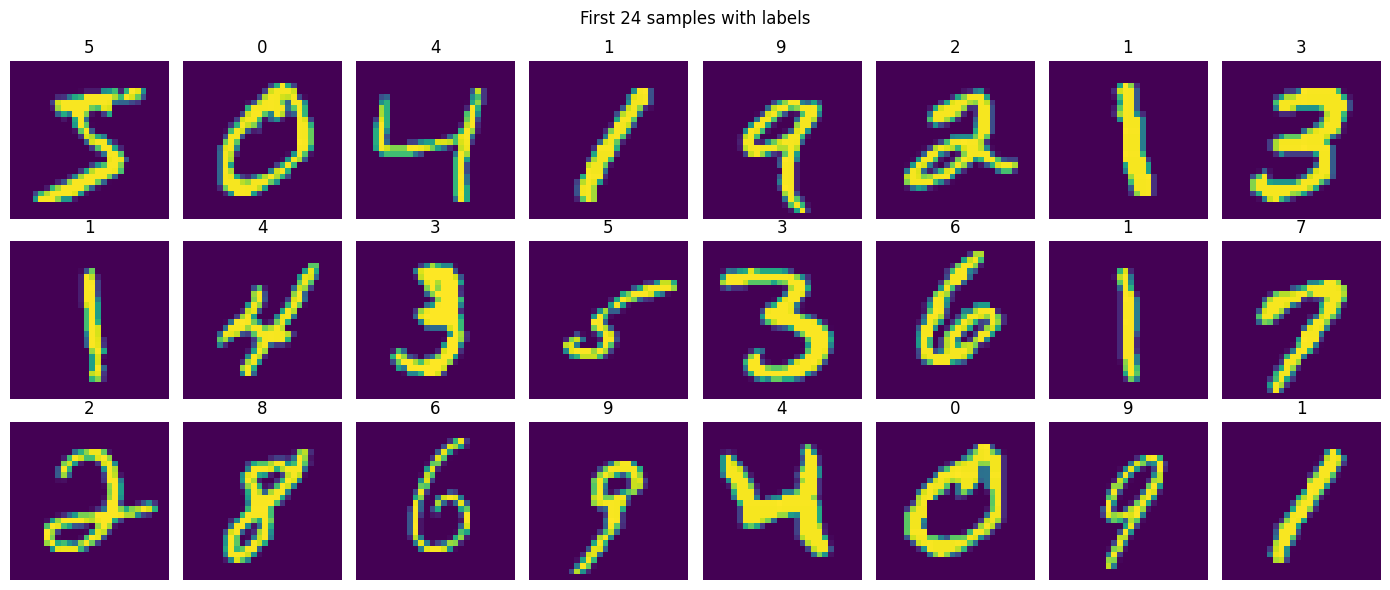

In [4]:
images, labels = load_lab02_data()

---
# Part 1 - Preprocessing [2 pts]


In this lab, we will create different feautre descriptors from digits. However, we will not use all images in the dataset. We will focus on the digits "0" and "4".

## 1.1 Selection (1 pt)

**Q1 (1 pt)** Your first task is to complete the function `extract_label` such that it selects from the input data only the images that are labeled as a given `target_label`. This function will be used to extract 0s and 4s from the data cohort. When running the code, the plots should only show you samples that are 0s (first plot) and 4s (second plot)

In [5]:
def extract_label(images: np.ndarray, labels: np.ndarray, target_label: int):
    """
    The function returns only the images that have target_label as labels.
    
    Args
    ----
    images: np.ndarray (N, 28, 28)
        Source images - handwritten digits 
    labels: np.ndarray (N)
        List of labels associated with the input image
    target_label: int
        Selected target label

    Return
    ------
    img_extract: np.ndarray (M, 28, 28)
        Extracted images that have target_label as label (M should be lower than N).
    """

    n, d, _ = np.shape(images) 
    img_extract = np.zeros((30, d, d))
    
    # ------------------
    # Your code here ... 
    # ------------------

    selected_img = []

    for i in range(n):
        if labels[i] == target_label:
            selected_img.append(images[i])

    img_extract = np.array(selected_img)
    
    return img_extract

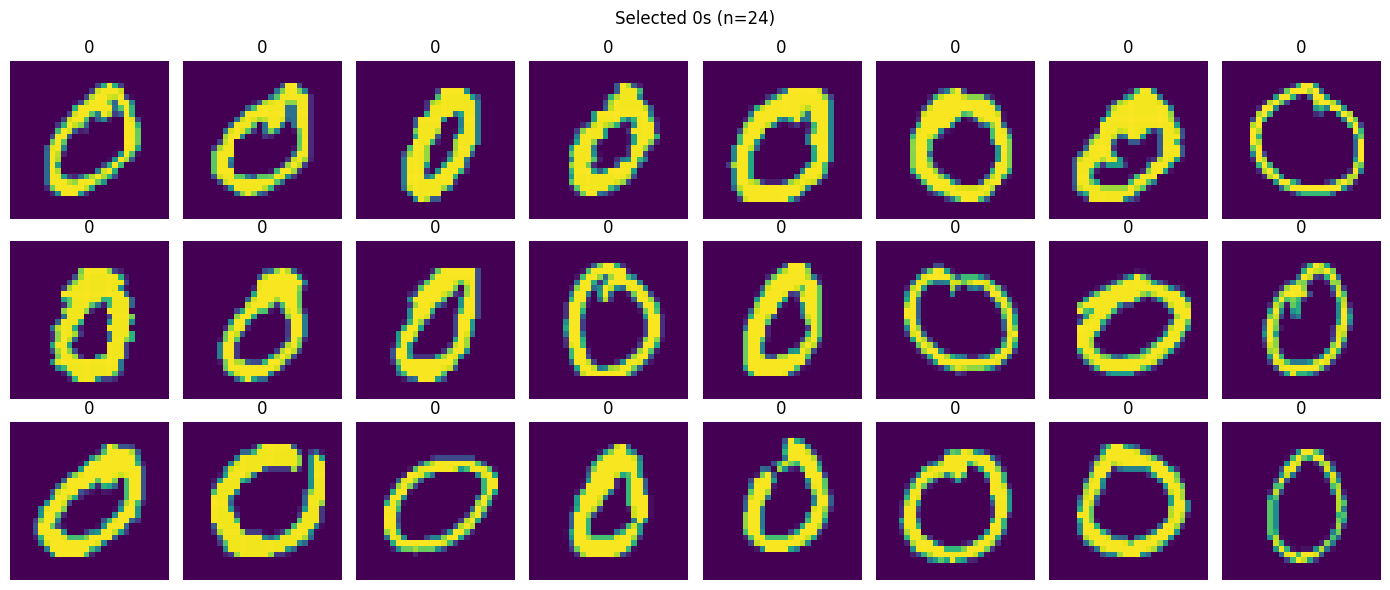

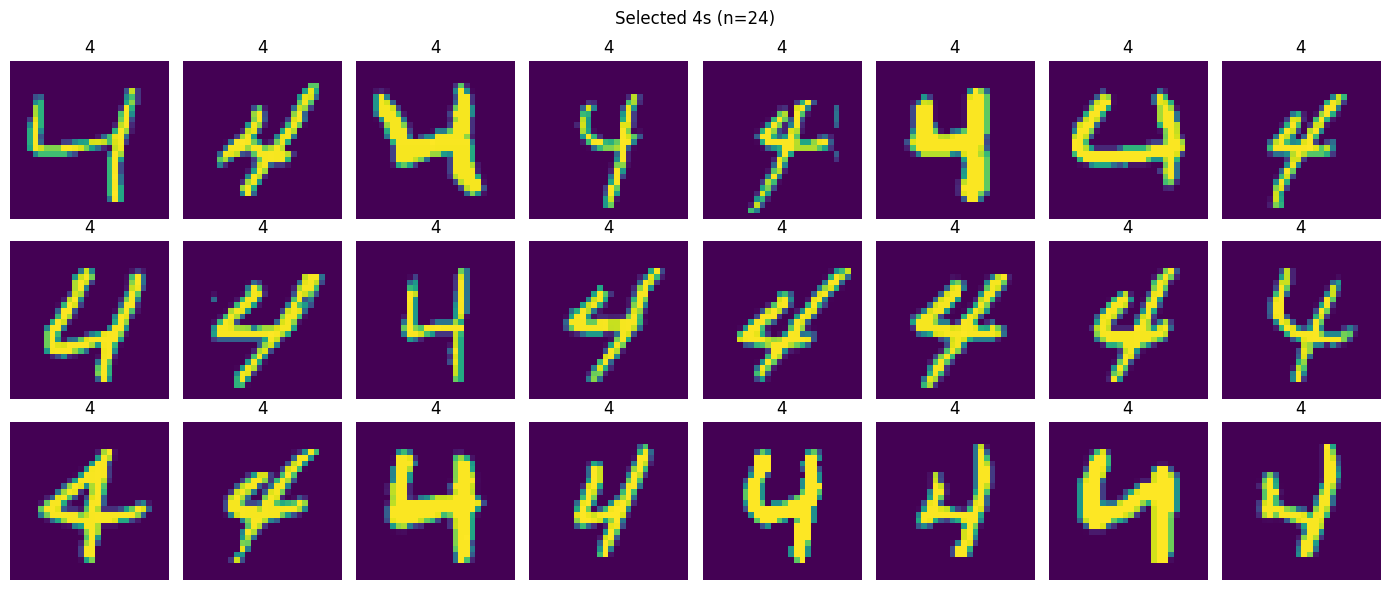

In [6]:
################################################################
############################ TEST ##############################
################################################################

images_a, images_b = test_1_1(extract_label, images, labels)

## 1.2 Preprocessing (1 pt)

Before computing the Fourier descriptors we need to preprocess the images.

* **Q1 (1 pt)**: Complete the function `preprocess` such that it cleans the input images. Take a look at the example images above and try to think what could be improved to allow better uniformity of the data. Take advantage of what you have learned in the previous lab.

In [7]:
def preprocess(images: np.ndarray):
    """
    Apply the processing step to images to achieve better data uniformity.
    
    Args
    ----
    images: np.ndarray (N, 28, 28)
        Source images

    Return
    ------
    img_process: np.ndarray (N, 28, 28)
        Processed images.
    """

    # Get the shape of input data and set dummy values
    n, d, _ = np.shape(images) 
    img_process = np.zeros_like(images)
    
    # ------------------
    # Your code here ... 
    # ------------------

    for i in range(n):
        # 1) binarization
        bi_threshold = 100 # determined through iterative trials --> limit = 170 / 100 = prime des 0 (sauf pour le plus fin???) mais comble un peu les 4 :(
        img_process[i] = images[i] > bi_threshold
        # 2) morphological operations --> change order? modify parameters?
        #img_process[i] = remove_small_objects(img_process[i], min_size=30) # removes noise (foreground specks) --> INUTILE JE PENSE
        img_process[i] = remove_small_holes(img_process[i], area_threshold=20)
        #img_process[i] = opening(img_process[i], disk(1)) # removes small foreground noise --> !!mauvaise idée car ouvre des 0!!
        img_process[i] = closing(img_process[i], disk(1.5)) # fills small holes in the digit --> utile car ça comble les trous mais pb avec les 4
    
    return img_process

/tmp/ipykernel_2012472/86088086.py:30: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  img_process[i] = remove_small_holes(img_process[i], area_threshold=20)


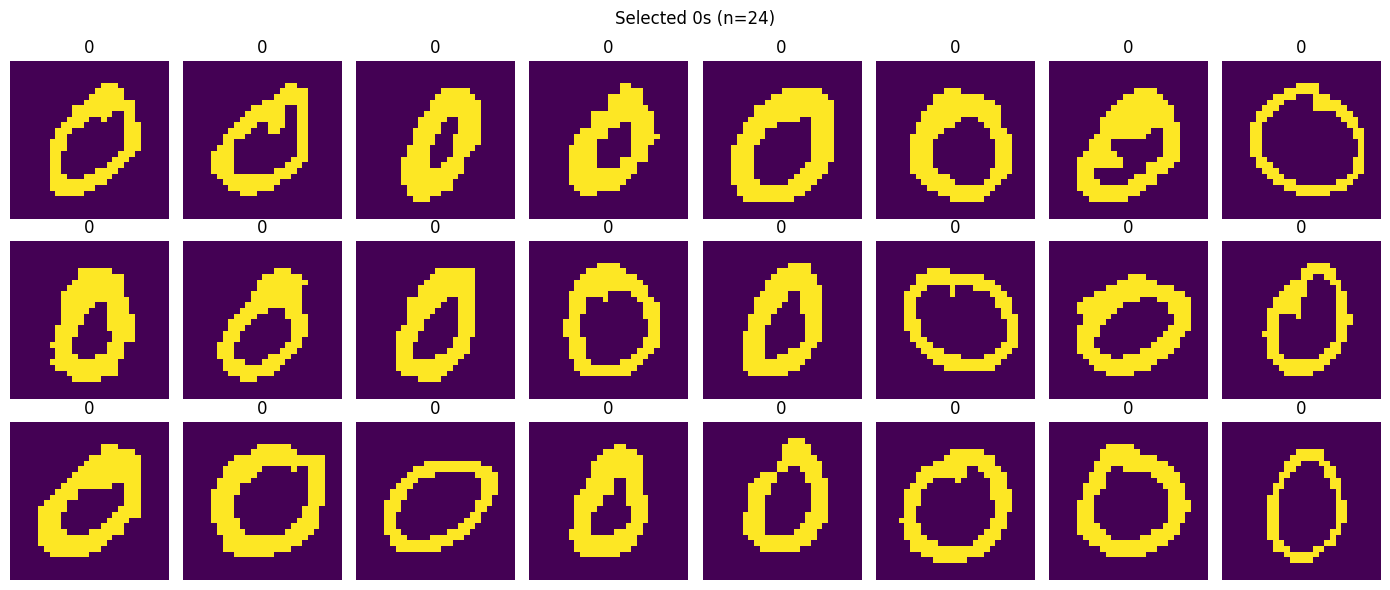

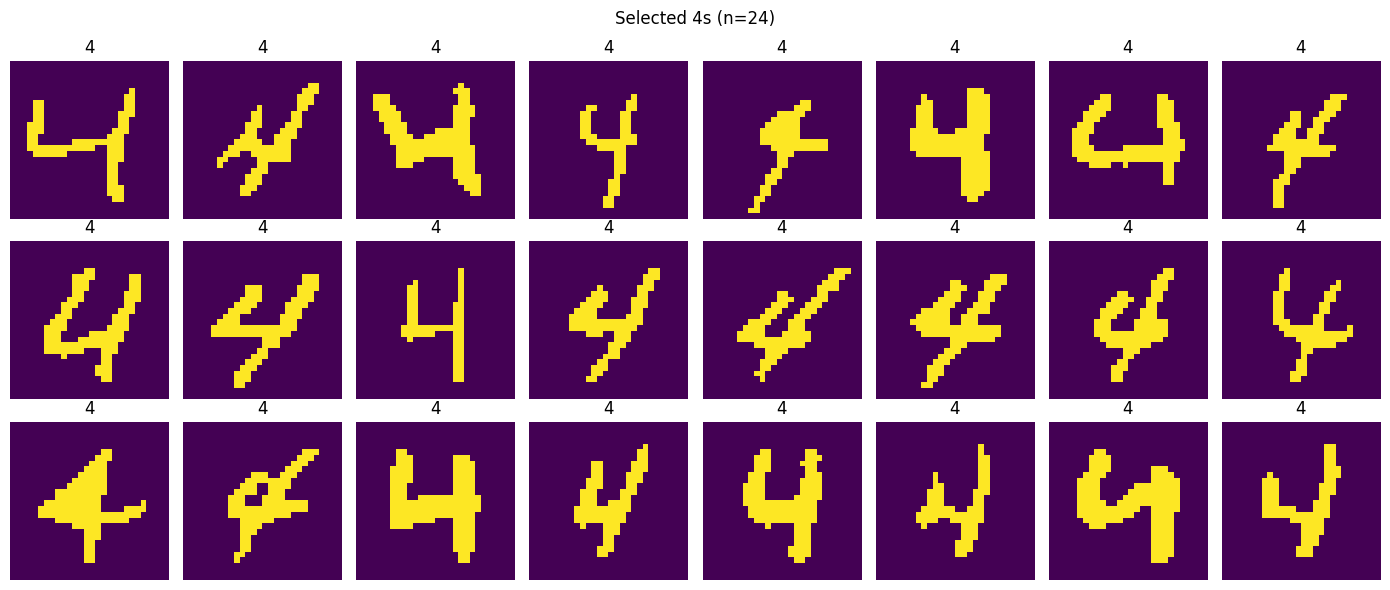

In [8]:
################################################################
############################ TEST ##############################
################################################################

images_p_a, images_p_b = test_1_2(preprocess, images_a, images_b)

---
# Part 2 - Fourier Descriptors [17 pts]


## 2.1. Get contour and descriptors (9 pts)

In this section, we will create Fourier descriptors from digits. The next step in our pipeline will be to detect the contours. To do so you can use existing algorithm available online such as `find_contours`([doc](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.find_contours)) from skcit-image or `findContours` ([doc](https://docs.opencv.org/4.x/d3/dc0/group__imgproc__shape.html#gadf1ad6a0b82947fa1fe3c3d497f260e0)) from opencv. Pay attention to the coordinate system when using the contour detection function (is the first component x or y coordinate?).

* **Q1 (2 pts)**: Complete the function `find_contour` below such that it returns the contour estimations of the given images. The provided `display_samples` function will display the returned contours for a subset of images.

In [9]:
# which method is the best (CV vs sklearn)?? also how do we check the coordinate system of each one?

def find_contour(images: np.ndarray):
    """
    Find the contours for the set of images
    
    Args
    ----
    images: np.ndarray (N, 28, 28)
        Source images to process

    Return
    ------
    contours: list of np.ndarray
        List of N arrays containing the coordinates of the contour. Each element of the 
        list is an array of 2d coordinates (K, 2) where K depends on the number of elements 
        that form the contour. 
    """

    # Get number of images to process
    N, _, _ = np.shape(images)
    # Fill in dummy values (fake points)
    contours = [np.array([[0, 0], [1, 1]]) for i in range(N)]

    # ------------------
    # Your code here ... 
    # ------------------

    for i in range(N):
        image = images[i]

        # openCV version -> PB = OPENCV FINDCONTOUR RETURNS TUPLES, NOT LISTS!!!!
        #contours[i], hierarchy = cv2.findContours(image, mode=cv2.RETR_CCOMP, method=cv2.CHAIN_APPROX_NONE)
        #contours[i] = contours[i].squeeze(axis=1)
        
        # or use skimage -> returns list:
        # /!\ returns [row=y, column=x] coordinates /!\
        contours[i] = find_contours(image, level=0.5) # play with level parameter --> HOW????
        largest_contour = max(contours[i], key=lambda c: len(c))
        largest_contour = largest_contour[:, ::-1]  # swap coordinate system
        contours[i] = largest_contour

    return contours
    

1000


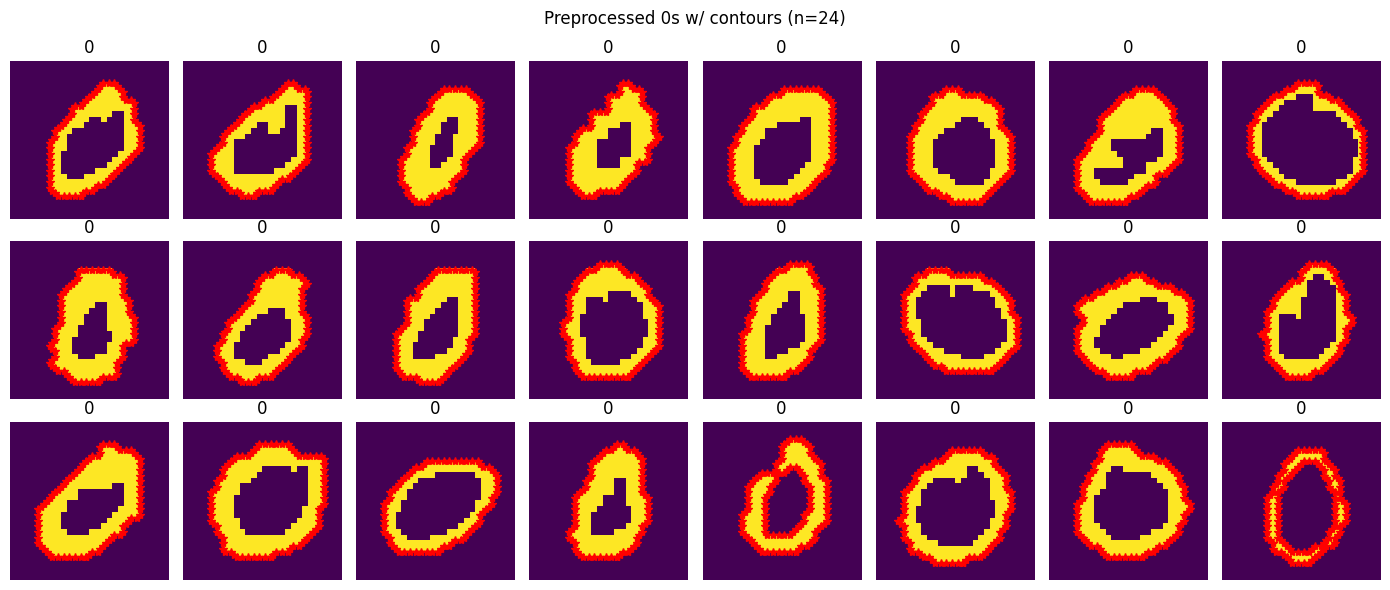

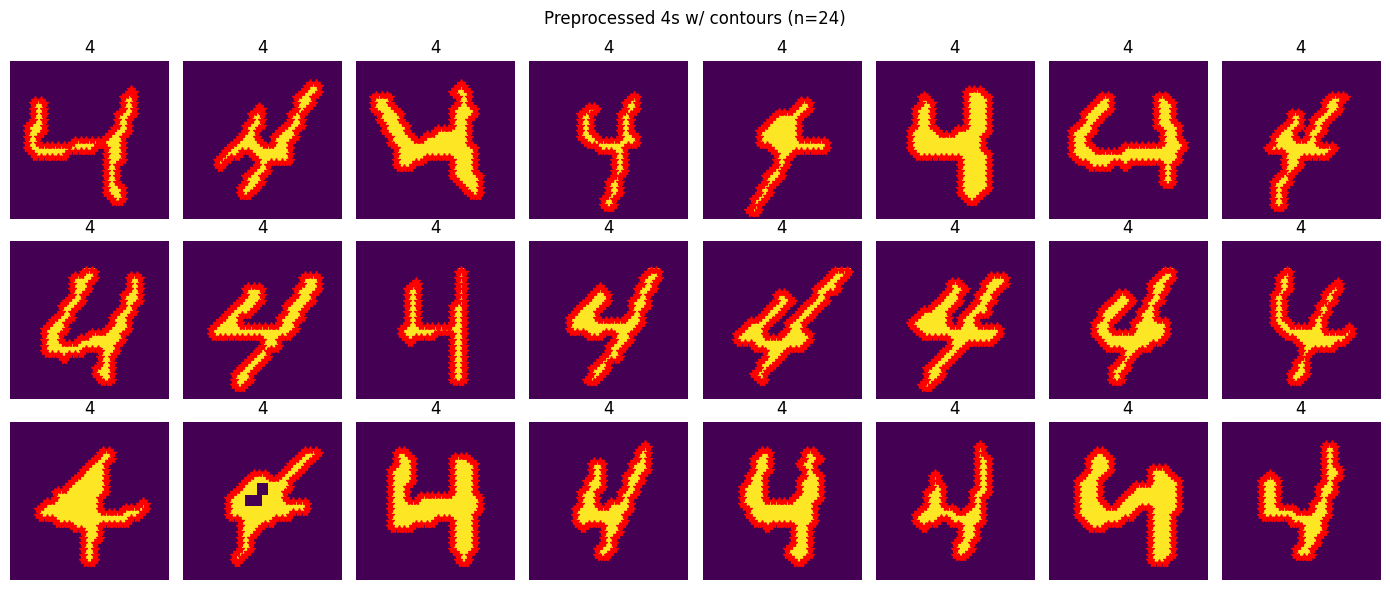

In [10]:
################################################################
############################ TEST ##############################
################################################################

cnt_p_a, cnt_p_b = test_2_1(find_contour, images_p_a, images_p_b)


Now that we are able to properly detect shape contours, we can finally compute Fourier descriptors. However, we still face a small issue. The allow a fair comparison between the Fourier descriptors we need to ensure that all descriptors have the same length.

* **Q2 (2 pts)**: Implement the function `compute_descriptor_padding` that takes as input the computed contours from before and returns the Fourier descriptors for each contour. Use `fft` ([doc](https://numpy.org/doc/stable/reference/generated/numpy.fft.fft.html#numpy.fft.fft)) from Numpy to compute the transformation. Use the `n_sample` argument to set the number of points to consider per contour. If the contour is longer than `n_sample` discard the extra points. If the contour is shorter than `n_sample`, use 0 paddings. Make sure that the first element of the descriptor represent the continuous component in the frequency domain.

In [11]:
def compute_descriptor_padding(contours: np.ndarray, n_samples: int = 11):
    """
    Compute Fourier descriptors of input images
    
    Args
    ----
    contours: list of np.ndarray
        List of N arrays containing the coordinates of the contour. Each element of the 
        list is an array of 2d coordinates (K, 2) where K depends on the number of elements 
        that form the contour. 
    n_samples: int
        Number of samples to consider. If the contour length is higher, discard the remaining part. If it is shorter, add padding.
        Make sure that the first element of the descriptor represents the continuous component.

    Return
    ------
    descriptors: np.ndarray complex (N, n_samples)
        Computed complex Fourier descriptors for the given input images
    """

    N = len(contours)
    # Look for the number of contours
    descriptors = np.zeros((N, n_samples), dtype=np.complex128)

    # ------------------
    # Your code here ... 
    # ------------------

    for i in range(N):
        K = np.shape(contours[i])[0]

        # convert to complex format: x + j*y (needed for zero-padding bc fft?????)
        complex_ith_contour = contours[i][:, 0] + 1j * contours[i][:, 1]

        if K >= n_samples:
            descriptors[i] = np.fft.fft(complex_ith_contour[:n_samples])
        else:
            padded_contour = np.zeros(n_samples, dtype=np.complex128)
            padded_contour[:K] = complex_ith_contour
            descriptors[i] = np.fft.fft(padded_contour)

    return descriptors


The code below uses the `plot_features` function to display the computed Fourier descriptors. We display the real, imaginary, and absolute components, respectively. Each color depicts a different digit. We use 2D plots to highlight the clustering capability of the components.
* **Q3 (1 pt)**: Comment on the quality of the Fourier descriptors. Do you think they are good feature descriptors? (justify)
    * **Answer**: ...
* **Q4 (1 pt)**: Knowing that we used `n_samples=11` to compute the Fourier transform, what do the components 0, 1, 5, and 10 represent as frequencies? (high, medium, constant, etc.)
    * **Answer**: ...

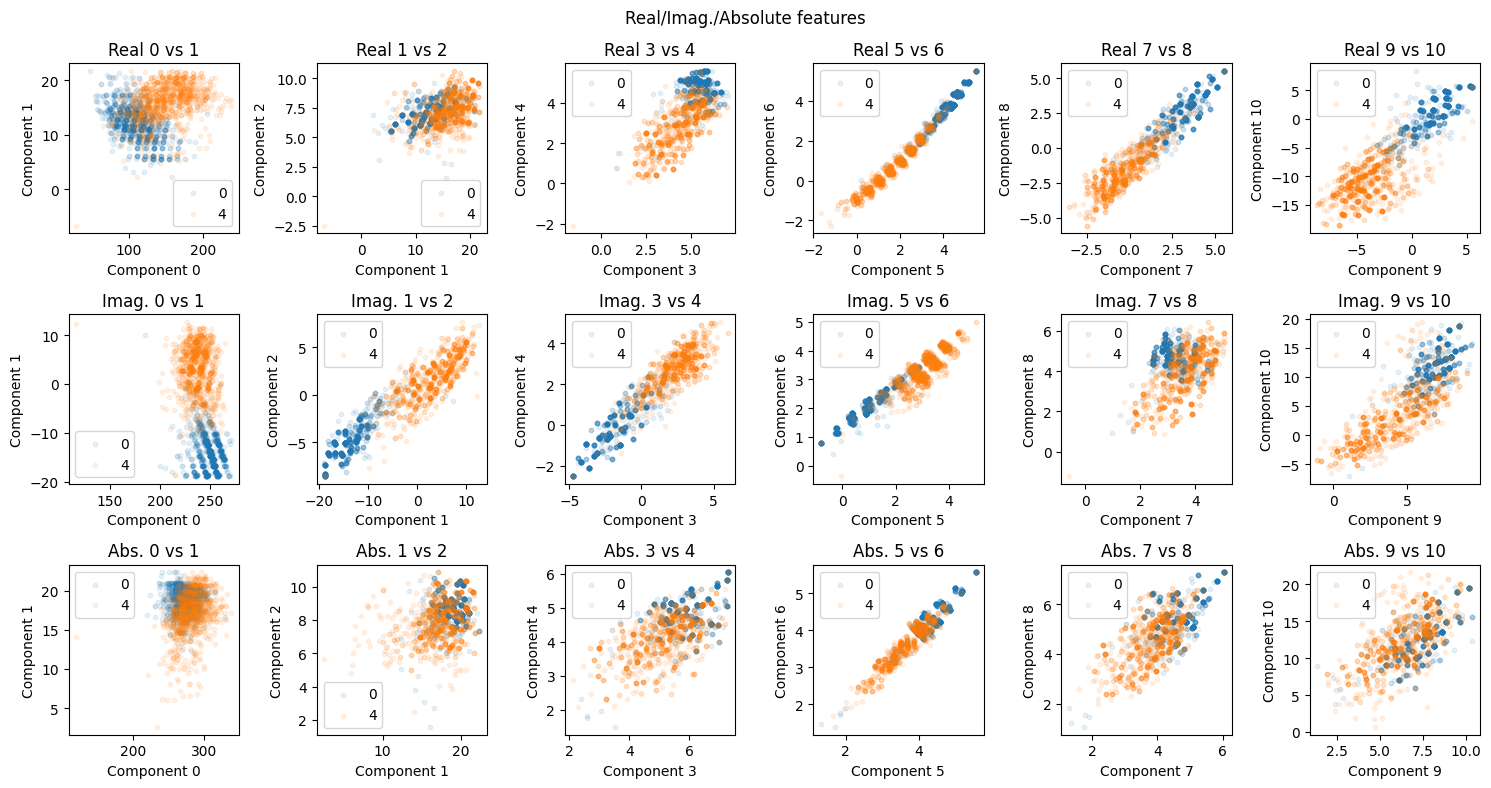

In [12]:
################################################################
############################ TEST ##############################
################################################################

test_2_1_2(compute_descriptor_padding, cnt_p_a, cnt_p_b)

As you might have realized before, the computed Fourier descriptors do not help us to find an optimal separation between the digits. This mainly comes from the fact that using 0 padding is a cheap and inefficient way to ensure homogeneity in length for descriptors. A better solution would be to ensure that we have the same number of points along the contour for each digit. To do so, we need to implement a new function that will resample the contour such that we always have the same number of points no matter the shape.

* **Q5 (2 pts)**: Implement the function `linear_interpolation` that takes as input the contours with various lengths and the wanted number of samples per contour for resampling. For each contour, resample the points such that each contour has the same length `n_samples`. We want the points to be uniformly distributed (same distance between points) along the contour. You can use for example the function `interp` ([doc](https://numpy.org/doc/stable/reference/generated/numpy.interp.html)) from Numpy to perform the interpolation. The function `display_samples` will display the contour for different lengths.

**Hint**: Think about the contour as two distinct signals x(t) and y(t) that are evaluated at different time steps $t$. Here the time steps can be seen as the Euclidean distance between consecutive samples $t_i$ = $ \sum_{j=1}^{j \leq i} \sqrt{(x_{j} - x_{j-1})^2 + (y_{j} - y_{j-1})^2}$, and $t_0 = 0$. The aim here is to resample the function at new time steps $t_i' = i * \frac{t_{N-1}}{n_{samples} + 1}$ where $n_{samples}$ is the new number of points.

In [13]:
def linear_interpolation(contours: np.ndarray, n_samples: int = 11):
    """
    Perform interpolation/resampling of the contour across n_samples.
    
    Args
    ----
    contours: list of np.ndarray
        List of N arrays containing the coordinates of the contour. Each element of the 
        list is an array of 2d coordinates (K, 2) where K depends on the number of elements 
        that form the contour. 
    n_samples: int
        Number of samples to consider along the contour.

    Return
    ------
    contours_inter: np.ndarray (N, n_samples, 2)
        Interpolated contour with n_samples
    """

    N = len(contours)
    contours_inter = np.zeros((N, n_samples, 2))
    
    # ------------------
    # Your code here ... 
    # ------------------

    for i, c in enumerate(contours):
        x = c[:,0]
        y = c[:,1]
        K = len(c)
        t = np.zeros(K)

        # compute time steps array t (cumulative distance along contour) --> on peut aussi utiliser euclidean_distances importé mais rien capté
        for j in range(1, K):
            dist = np.sqrt((x[j] - x[j-1])**2 + (y[j] - y[j-1])**2)
            t[j] = t[j-1] + dist
        
        # new time steps from 0 to t[-1] with n_samples nb of pts
        t_new = np.linspace(0, t[-1], n_samples)

        x_new = np.interp(t_new, t, x)
        y_new = np.interp(t_new, t, y)
        contours_inter[i,:,0] = x_new
        contours_inter[i,:,1] = y_new

    return contours_inter


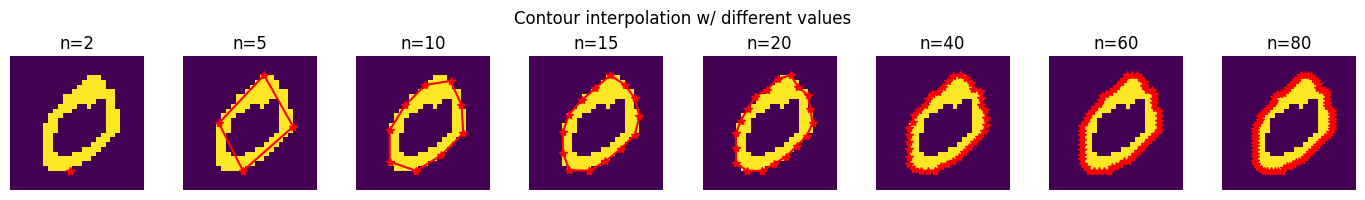

In [14]:
################################################################
############################ TEST ##############################
################################################################

test_2_1_5(linear_interpolation, cnt_p_a, images_p_a)

Now that we have implemented our resampling approach we can revisualize the clustering efficiency of our descriptors.

* **Q6 (1 pt)**: Comment on the quality of the descriptors. Is it better than before? is there a frequency/component that appears to work better? Does it make sense?
    * **Answer**: ...

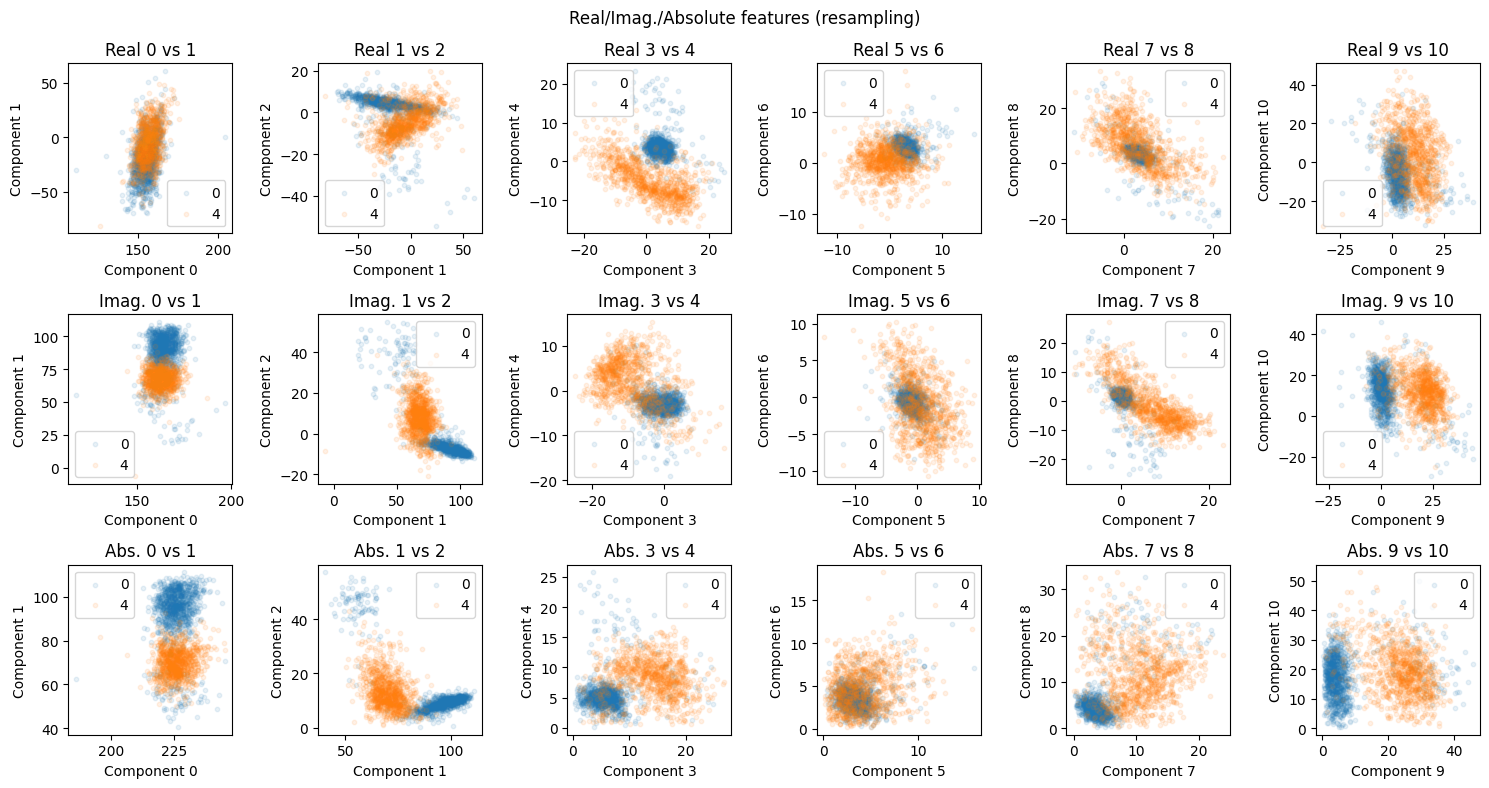

In [15]:
################################################################
############################ TEST ##############################
################################################################

feat_a, feat_b = test_2_1_6(compute_descriptor_padding, linear_interpolation, cnt_p_a, cnt_p_b, n_samples=11)

## 2.2. Reconstruction (2 pts)

For this part, we will now try to go the other way. Given a Fourier descriptor we will try to retrieve the original shape. 
* **Q1 (1 pt)** Implement the function `compute_reverse_descriptor` that takes as input a single descriptor and reverses it to x and y coordinates given a number of samples `n_samples`. Use the function `ifft` ([doc](https://numpy.org/doc/stable/reference/generated/numpy.fft.ifft.html)) from Numpy.

In [16]:
def compute_reverse_descriptor(descriptor: np.ndarray, n_samples: int = 11):
    """
    Reverse a Fourier descriptor to xy coordinates given a number of samples.
    
    Args
    ----
    descriptor: np.ndarray (D,)
        Complex descriptor of length D.
    n_samples: int
        Number of samples to consider to reverse transformation.

    Return
    ------
    x: np.ndarray complex (n_samples,)
        x coordinates of the contour
    y: np.ndarray complex (n_samples,)
        y coordinates of the contour
    """

    x = np.zeros(n_samples)
    y = np.zeros(n_samples)
    
    # ------------------
    # Your code here ... 
    # ------------------

    reverse_fourier = np.fft.ifft(descriptor)

    if np.shape(reverse_fourier)[0] > n_samples:
        reverse_fourier = reverse_fourier[:n_samples]

    for i in range(n_samples):
        x[i] = reverse_fourier[i].real
        y[i] = reverse_fourier[i].imag

    return x, y


With the function `plot_reconstruction` we plot an example of the reconstruction of the digits. We display the result as we progressively add more frequencies. We start with the first component (component 0) and then add frequency pairs from low to high frequencies.

* **Q2 (1 pt)**: Based on your observation, do you think 11 samples are enough to properly describe the digits below? (justify)
    * **Answer**: ...

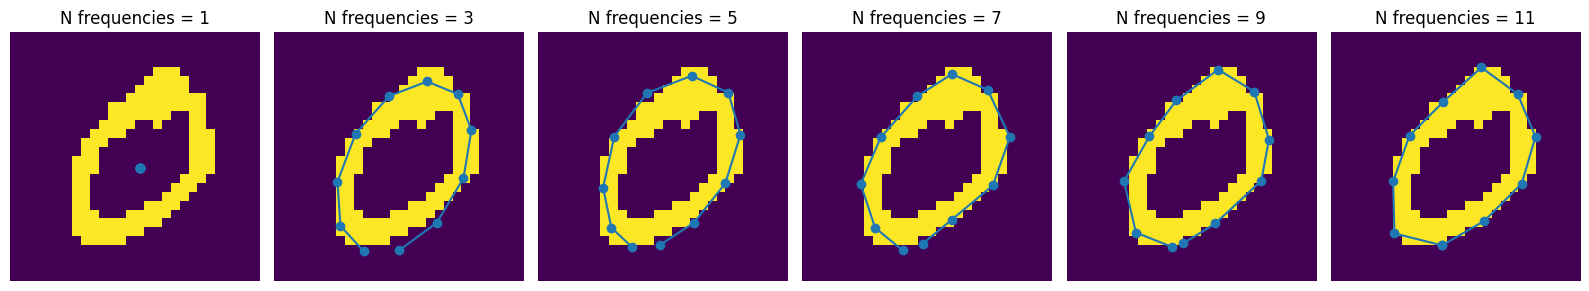

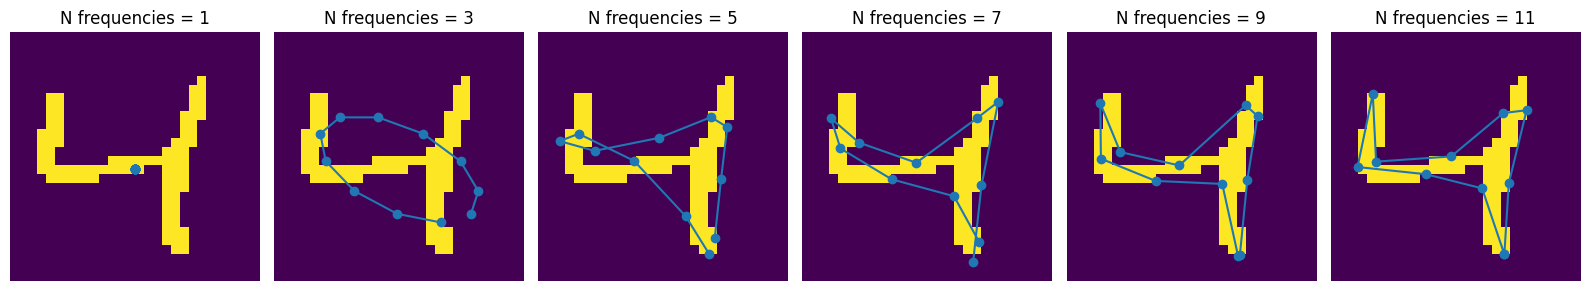

In [17]:
################################################################
############################ TEST ##############################
################################################################

test_2_2(images_p_a , images_p_b, feat_a, feat_b, compute_reverse_descriptor)

## 2.3. Invariance (6 pts)

For the last part with Fourier descriptors, we will check for descriptors invariance. As seen in class, if handled properly Fourier descriptors can be invariant to translation, rotation, and scaling.

* **Q1 (3 pts)**: Implement the functions `apply_rotation`, `apply_scaling`, and `apply_translate` to apply random rotation, scaling, and translation to input images. For scaling and translation, we recommend avoiding large values where the digits are cropped (out of frame). You can use the `random` package ([doc](https://numpy.org/doc/1.16/reference/routines.random.html)) from Numpy to generate random values.

In [32]:
from skimage.transform import rescale, AffineTransform, warp

def apply_rotation(img: np.ndarray):
    """
    Apply random rotation to input the image
    
    Args
    ----
    image: np.ndarray (28, 28)
        Source images
        
    Return
    ------
    rotated: np.ndarray (28, 28)
        Rotated source images
    """

    rotated = np.zeros_like(img)
    
    # ------------------
    # Your code here ... 
    # ------------------
    # np.random.seed(42)
    rotation_degree = np.random.uniform(0, 360)
    
    rotated = rotate(img, rotation_degree)
    
    return rotated


def apply_scaling(img: np.ndarray):
    """
    Apply random scaling to input image
    
    Args
    ----
    image: np.ndarray (28, 28)
        Source images
        
    Return
    ------
    scaled: np.ndarray (28, 28)
        Scaled source images
    """
    
    scaled = np.zeros_like(img)
    
    # ------------------
    # Your code here ... 
    # ------------------
    # np.random.seed(42)
    scale = np.random.uniform(0,2)

    scaled = rescale(img, scale) 
    
    return scaled

def apply_translate(img: np.ndarray):
    """
    Apply random x and y translation to input image
    
    Args
    ----
    image: np.ndarray (28, 28)
        Source images
        
    Return
    ------
    translated: np.ndarray (28, 28)
        Translated source images
    """
    
    translated = np.zeros_like(img)
    
    # ------------------
    # Your code here ... 
    # ------------------
    # np.random.seed(42)
    ratiox = np.random.uniform(0, 0.75)
    ratioy = np.random.uniform(0, 0.75)

    width, height = img.shape

    tx = width * ratiox
    ty = height * ratioy

    transform = AffineTransform(translation=(tx,ty))

    translated = warp(img, transform)
    
    return translated


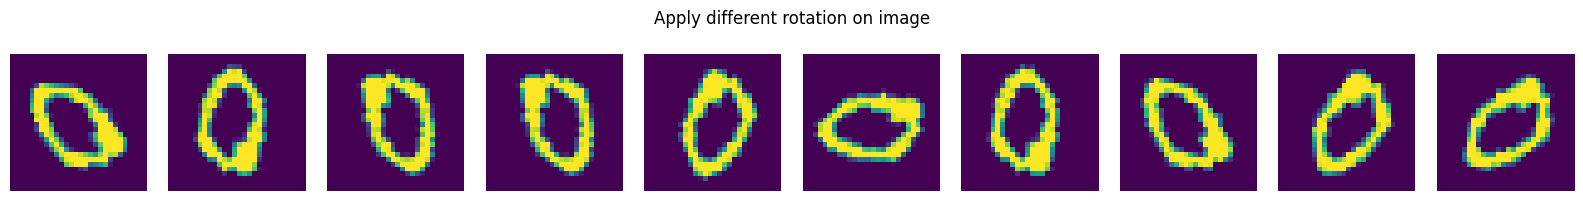

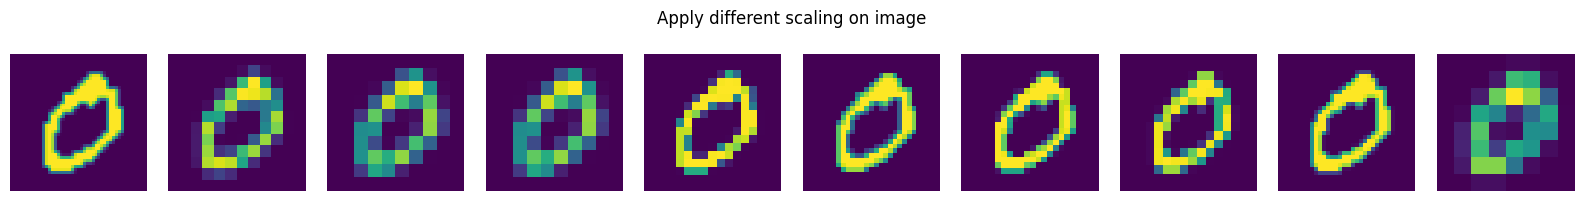

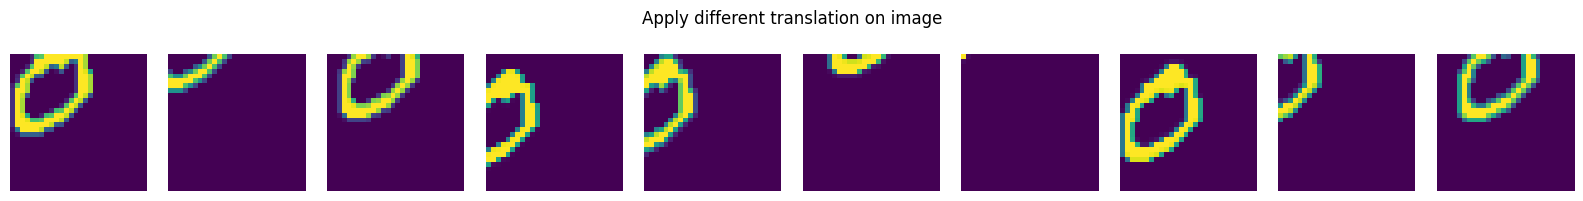

In [33]:
################################################################
############################ TEST ##############################
################################################################

test_2_3(apply_rotation, apply_scaling, apply_translate, images_p_a[0])

Now that we implemented our transformation, we can test for feature invariance. To assess the robustness of the Fourier descriptors to image transformations, we compute the error between the original descriptors (before transformation) to the one after transformation. 

* **Q2 (1 pt)**: Complet the function `translation_invariant` to make the Fourier deciptor invariant to translation. Does the error decrease after treatment for translation invariance? Is it null, if not why?
    * **Answer**: ...

In [38]:
def translation_invariant(features):
    """
    Make input Fourier descriptors invariant to translation.

    Args
    ----
    features: np.ndarray (N, D)
        The Fourier descriptors of N images over D features.

    Return
    ------
    features_inv: np.ndarray (N, K)
        The Fourier descriptors invariant to translation of N images 
        over K (K <= N) features.
    """

    # Set default values
    features_inv = np.zeros_like(features)
    
    # ------------------
    # Your code here ... 
    # ------------------
    features_inv = features[:,1:]
    
    return features_inv

In [39]:
################################################################
############################ TEST ##############################
################################################################

feat_t_a = test_2_3_2(translation_invariant, find_contour, apply_translate, compute_descriptor_padding, linear_interpolation,images_p_a, feat_a)

ValueError: max() arg is an empty sequence

* **Q3 (1 pt)**: Complet the function `rotation_invariant` to make the Fourier deciptor invariant to rotation. Does the error decrease after treatment for rotation invariance? Do you think that selecting specific rotation angles might help the error to decrease even lower?
    * **Answer**: ...

In [40]:
def rotation_invariant(features):
    """
    Make input Fourier descriptors invariant to rotation.

    Args
    ----
    features: np.ndarray (N, D)
        The Fourier descriptors of N images over D features.

    Return
    ------
    features_inv: np.ndarray (N, K)
        The Fourier descriptors invariant to rotation of N images 
        over K (K <= N) features.
    """

    # Set default values
    features_inv = np.zeros_like(features)
    
    # ------------------
    # Your code here ... 
    # ------------------
    features_inv = np.abs(features)

    return features_inv

In [41]:
################################################################
############################ TEST ##############################
################################################################

test_2_3_3(rotation_invariant, find_contour, apply_rotation, compute_descriptor_padding, linear_interpolation,images_p_a, feat_a)

ValueError: max() arg is an empty sequence

* **Q4 (1 pt)**: Complet the function `scaling_invariant` to make the Fourier deciptor invariant to scaling. Does the error decrease after treatment for scaling invariance? Is it null? Why?
    * **Answer**: ...

In [42]:
def scaling_invariant(features):
    """
    Make input Fourier descriptors invariant to scaling.

    Args
    ----
    features: np.ndarray (N, D)
        The Fourier descriptors of N images over D features.

    Return
    ------
    features_inv: np.ndarray (N, K)
        The Fourier descriptors invariant to scaling of N images 
        over K (K <= N) features.
    """

    # Set default values
    features_inv = np.zeros_like(features)
    
    # ------------------
    # Your code here ... 
    # ------------------
    features_inv = features / features[:,1]

    return features_inv

In [43]:
################################################################
############################ TEST ##############################
################################################################

test_2_3_4(scaling_invariant, find_contour, apply_scaling, compute_descriptor_padding, linear_interpolation,images_p_a, feat_t_a, feat_a)

NameError: name 'feat_t_a' is not defined

---
# PART 3 - Other descriptors [8 pts]

## 3.1 Distance map (5 pts)

In this part, we will learn how to use a distance map as a feature descriptor. 

* **Q1 (1 pt)**: To compute a distance map we first need a reference pattern. Complete the function `reference_pattern`. The function takes as input a list of images and computes the reference pattern as the average of all shapes.

In [44]:
def reference_pattern(imgs):
    """
    Compute the reference pattern for a given set of images. The reference pattern 
    is estimated as the average of all images of the same pattern.

    Args
    ----
    imgs: np.ndarray (N, 28, 28)
        Source images
        
    Return
    ------
    pattern: np.ndarray (28, 28)
        Thresholded reference pattern that is the average of all shapes.
    """

    # Initialize pattern
    pattern = np.zeros((imgs[0].shape[0], imgs[0].shape[1]))
    
    # ------------------
    # Your code here ... 
    # ------------------
    pattern = np.mean(imgs, axis=0)
   
    return pattern

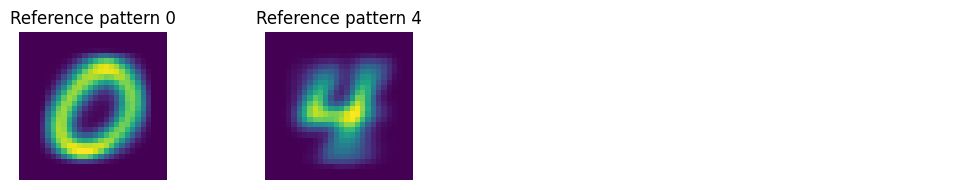

In [45]:
################################################################
############################ TEST ##############################
################################################################

pattern_a, pattern_b = test_3_1(reference_pattern, images_p_a, images_p_b)

* **Q2 (2 pts)**: The next part will be to compute a distance map from the generated pattern. By pre-computing the distance map we can speedup the inference time. Complete the function `compute_distance_map`. We expect the values of the map to represent the distances to the closest pattern contour. If needed, can take advantage of the functions you wrote in PART2 to detect and resample contours.

In [46]:
def compute_distance_map(pattern: np.ndarray):
    """
    Compute the distance map for the given pattern. The values of the map are computed as 
    the distance to the closest pattern contour.

    Args
    ----
    pattern: np.ndarray (28, 28)
        Pattern to process

    Return
    ------
    distance_map: np.ndarray (28, 28)
        Distance map where each entry is the distance to the closest pattern contour (shortest 
        distance to pattern)
    """
    
    # Initialize dummy values
    distance_map = np.zeros_like(pattern)
    
    # ------------------
    # Your code here ... 
    # ------------------
    pattern_contour = find_contour(pattern)[0]

    # Distance from contour using euclidean distance
    x_len, y_len = pattern.shape
    grid_coords = np.column.stack((x_len.ravel(), y_len.ravel()))

    distance_map.flat = min(euclidean_distances(grid_coords, pattern_contour))
    
    return distance_map


In [47]:
################################################################
############################ TEST ##############################
################################################################

map_a, map_b = test_3_1_2(compute_distance_map, pattern_a, pattern_b)

ValueError: not enough values to unpack (expected 3, got 2)

* **Q3 (2 pts)**: For the last part, implement the function `compute_distance` that uses the precomputed distance map to evaluate the distance to all images. Note that for each image you should return the average of distances. As before, for each digit, you can compute the contour and estimate the point-to-point distance by evaluating the distance map at the xy contour coordinates.

In [48]:
def compute_distance(imgs, d_map):
    """
    Compute the distances for each image with respect to the reference pattern using the precomputed 
    distance map. The final distance is the average of all distances from the image's contour points 
    to the reference pattern.

    Args
    ----
    imgs: np.ndarray (N, 28, 28)
        Source images
    d_map: np.ndarray (28, 28)
        The precomputed distance map where each entry is the distance to the closest pattern contour 
        (shortest distance to pattern)
    
    Return
    ------
    dist: np.ndarray (N, )
        Averaged distance to pattern for each input image.
    """
    
    # Default values
    dist = np.zeros(len(imgs))

    # ------------------
    # Your code here ... 
    # ------------------
    img_contours = find_contour(imgs)

    for i, contour in enumerate(img_contours):
        dist[i] = np.mean(d_map[contour[:,0],contour[:,1]])
    
    return dist
    

In [49]:
################################################################
############################ TEST ##############################
################################################################

test_3_1_3(compute_distance, images_p_a, images_p_b, map_a, map_b)

NameError: name 'map_a' is not defined

## 3.2 Others (3 pts)

For the last part of the lab, we will compute other various visual features. 

* **Q1: (2 pts)**: Implement the function `compute_features` that estimates the digit's perimeter, area, compacity, and rectangularity. You can use the lecture to look for the definition of each feature. To help you with this task we strongly recommend using the `regionprops` ([doc](https://scikit-image.org/docs/stable/api/skimage.measure.html#skimage.measure.regionprops)) from scikit-image.
* **Q2: (1 pt)**: Which feature(s) seem(s) to show the best results to distinguish between both digits? (justify)
    * **Answer**: ...

In [52]:
def compute_features(imgs: np.ndarray):
    """
    Compute compacity for each input image.
    
    Args
    ----
    imgs: np.ndarray (N, 28, 28)
        Source images
        
    Return
    ------
    f_peri: np.ndarray (N,)
        Estimated perimeter length for each image
    f_area: np.ndarray (N,)
        Estimated area for each image
    f_comp: np.ndarray (N,)
        Estimated compacity for each image
    f_rect: np.ndarray (N,)
        Estimated rectangularity for each image
    """

    f_peri = np.zeros(len(imgs))
    f_area = np.zeros(len(imgs))
    f_comp = np.zeros(len(imgs))
    f_rect = np.zeros(len(imgs))
    
    # ------------------
    # Your code here ... 
    # ------------------
    for i, img in enumerate(imgs):
        props = regionprops(img)

        f_peri[i] = props[0]['perimeter']

        f_area[i] = props[0]['area']

        f_comp[i] = f_peri[i]**2/f_area[i]

        bbox = props[0]['bbox']
        bbox_area = (bbox[3] - bbox[1]) * (bbox[2] - bbox[0])        
        f_rect[i] = f_area[i]/bbox_area

    return f_peri, f_area, f_comp, f_rect


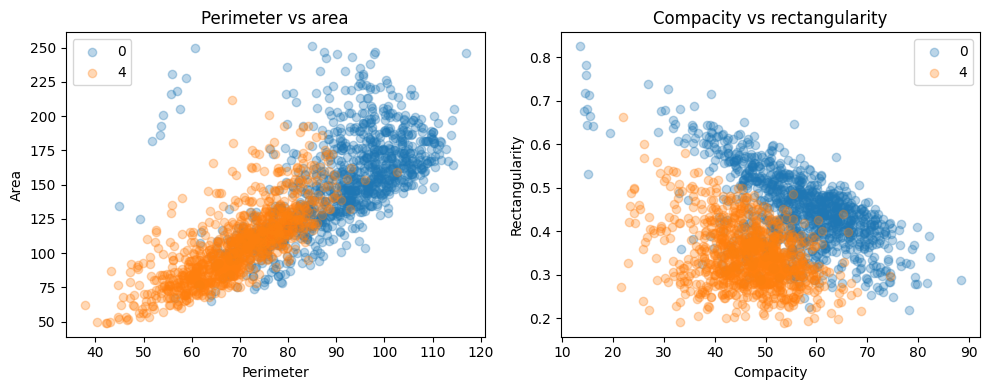

In [53]:
################################################################
############################ TEST ##############################
################################################################

test_3_2(compute_features, images_p_a, images_p_b)